Rapor öncelikle Gallup Dünya Anketinden elde edilen verileri kullanır. Her yıllık rapor, Dünya Mutluluk Raporu web sitesinden indirilmek üzere halka açıktır.Mutluluk puanını takip eden sütunlar, ekonomik üretim, sosyal destek, yaşam beklentisi, özgürlük, yolsuzluğun olmaması ve cömertlik olmak üzere altı faktörün her birine odaklanarak mutluluk ve Sürdürülebilir Kalkınma arasındaki bağlantıyı içerir. (Vikipedi)

World Happiness Report Official Website: https://worldhappiness.report/ 

Dünya Mutluluk Raporu, her ülkenin mutluluğunu belirtmek için belirteçler kullanır. Bir "Ladder Skoru" oluşturmak için toplanır ve daha sonra sonunda bir "Distopya + residual" puanı içerecek şekilde değiştirilir.
Göstergeler arasında:


*   Ladder score: Mutluluk puanı
*   Country name: Ülkelerin İsimleri (Afghanistan, Albenia, ...,Zimbabwe)
*   Life ladder: Yaşam kalitesi puanı (2.375 to 8.019)
*   Log GDP per capita: GSYİH (6.635 to 11.648)
*   Social support: Sosyal Destek (0.290 to 0.905)
*   Healthy life expectancy at birth: Sağlıklı yaşam yüzdesi (32.300 to 77.100)
*   Freedom to make life choices: Hayatı şekillendirmede özgürlük (0.258 to 0.985)
*   Generosity: Cömertlik (-0.335 to 0.698)
*   Perceptions of corruption : Yolsuzluk Algısı (0.035 to 0.983)

Distopya, dünyanın en mutsuz insanlarına sahip hayali bir ülkedir.Dünyanın en düşük gelirli, en düşük yaşam beklentisi, en düşük cömertlik, en çok yolsuzluk, en az özgürlük ve en az sosyal desteği olan bir ülkede hayat çok tatsız olacağından, Ütopya'nın aksine “Distopya” olarak anılır.

**Python Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px;
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import accuracy_score,classification_report
import keras
from keras.layers import Dense
from keras.models import Sequential

**Data Preperation**

In [2]:
df = pd.read_csv("world-happiness-report-2021.csv")
df.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798


In [3]:
#Hangisini daha fazla analiz için kullanacağımıza karar vermek için tüm sütunları göster
df.columns

Index(['Country name', 'Regional indicator', 'Ladder score',
       'Standard error of ladder score', 'upperwhisker', 'lowerwhisker',
       'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual'],
      dtype='object')

In [4]:
#Daha fazla analiz için kullanılmayan tüm sütunları bırakılmalı,Önce "Explained" kelimesini içeren sütunları bırak
explained_cols= df.columns.str.find("Explained")==0
df= df.loc[:, ~explained_cols]
#Now drop the rest of the columns which we'll not use
df= df.drop(columns=["Standard error of ladder score", "upperwhisker","lowerwhisker", "Ladder score in Dystopia", "Dystopia + residual"])
df.head()

,Country name,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Finland,Western Europe,7.842,10.775,0.954,72.0,0.949,-0.098,0.186
1,Denmark,Western Europe,7.620,10.933,0.954,72.7,0.946,0.030,0.179
2,Switzerland,Western Europe,7.571,11.117,0.942,74.4,0.919,0.025,0.292
3,Iceland,Western Europe,7.554,10.878,0.983,73.0,0.955,0.160,0.673
4,Netherlands,Western Europe,7.464,10.932,0.942,72.4,0.913,0.175,0.338


In [5]:
df.columns = ['country', 'regional', 'ladderScore', 'GDP', 'socialSupport', 'lifeExpect', 'freedomChoices', 'generosity','perceptionCorrupt']

In [6]:
continuous = ['GDP',
 'socialSupport',
 'lifeExpect',
 'freedomChoices',
 'generosity',
 'perceptionCorrupt']


📌Her sayısal değişkenin sayısı 149 olduğundan eksik değer yok gibi görünüyor.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            149 non-null    object 
 1   regional           149 non-null    object 
 2   ladderScore        149 non-null    float64
 3   GDP                149 non-null    float64
 4   socialSupport      149 non-null    float64
 5   lifeExpect         149 non-null    float64
 6   freedomChoices     149 non-null    float64
 7   generosity         149 non-null    float64
 8   perceptionCorrupt  149 non-null    float64
dtypes: float64(7), object(2)
memory usage: 10.6+ KB


In [8]:
df.isna().sum().where(lambda x: x>0).dropna()

Series([], dtype: float64)

📌Mutluluk puanı 2.52'den (en mutsuz ülke) 7.84'e (en mutlu ülke) ulaşıyor.<br>
📌Sosyal destek, yaşam seçimlerini yapma özgürlüğü ve yolsuzluk algısı değerleri 0 ile 1 arasında normal bir şekilde dağılmış görünmektedir.

In [9]:
df.describe()

,ladderScore,GDP,socialSupport,lifeExpect,freedomChoices,generosity,perceptionCorrupt
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,5.532839,9.432208,0.814745,64.992799,0.791597,-0.015134,0.727450
std,1.073924,1.158601,0.114889,6.762043,0.113332,0.150657,0.179226
min,2.523000,6.635000,0.463000,48.478000,0.382000,-0.288000,0.082000
25%,4.852000,8.541000,0.750000,59.802000,0.718000,-0.126000,0.667000
50%,5.534000,9.569000,0.832000,66.603000,0.804000,-0.036000,0.781000
75%,6.255000,10.421000,0.905000,69.600000,0.877000,0.079000,0.845000
max,7.842000,11.647000,0.983000,76.953000,0.970000,0.542000,0.939000


**EDA**

📌Batı Avrupa ve Kuzey Amerika bölgelerinin sağlıklı hayat yaşama beklentisi ve mutluluk skoru yüksek

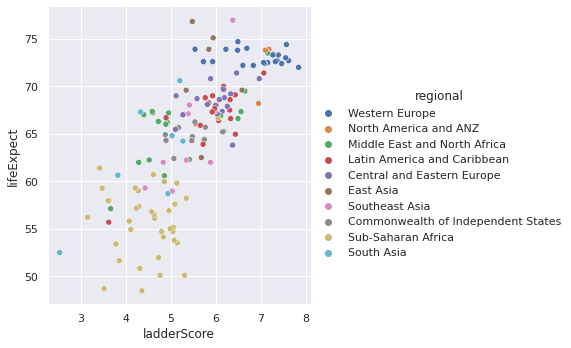

In [10]:
sns.set_theme()

sns.relplot(
    data=df,
    x='ladderScore', 
    y='lifeExpect', 
    hue='regional')

📌Bölgesel olarak gruplandırma ve mutluluk skoruna göre sıralama

In [11]:
df.groupby(['regional']).mean().sort_values('ladderScore')

,ladderScore,GDP,socialSupport,lifeExpect,freedomChoices,generosity,perceptionCorrupt
regional,,,,,,,
South Asia,4.441857,8.682571,0.703429,62.681000,0.765000,0.042714,0.797429
Sub-Saharan Africa,4.494472,8.075194,0.696750,55.886472,0.723194,0.013444,0.765944
Middle East and North Africa,5.219765,9.666118,0.797647,65.609118,0.716471,-0.079765,0.762235
Southeast Asia,5.407556,9.421444,0.820333,64.888444,0.909000,0.156333,0.709111
Commonwealth of Independent States,5.467000,9.401833,0.872500,65.009500,0.816917,-0.036000,0.725083
East Asia,5.810333,10.367667,0.860500,71.252167,0.763500,-0.062333,0.683333
Latin America and Caribbean,5.908050,9.370000,0.839500,67.076050,0.831750,-0.067700,0.792600
Central and Eastern Europe,5.984765,10.109059,0.887412,68.338412,0.797059,-0.078941,0.850529
Western Europe,6.914905,10.822714,0.914476,73.033095,0.858714,-0.003190,0.523095


📌Ülke bazında Mutluluk düzeyi (../8) <br>
  Finlandiya : 7.84 <br>
Türkiye : 4.94 <br>
Afganistan : 2.52 

In [12]:
fig = px.choropleth(df,
                    locations = "country",
                    color = "ladderScore",
                    locationmode = "country names"
                   );
fig.update_layout(title = "Happiness score Comparison by Countries");
fig.show();

In [13]:
fig = px.bar(df, y= 'ladderScore', x= 'country', orientation='v', color ='country',
                 labels={'Ladder score':'Mutluluk Endeksi'},
                 height=600)
fig.show()

In [14]:
# En mutlu ve en mutsuz ülke belirlemesi
# df.sort_values numerik değerleri ascending olarak sıralar
# 'ignore_index'=False, veri çerçevesinin orijinal dizini sıralamadan sonra değişmez

leat_happy_country=df.sort_values(by='ladderScore', ignore_index=True)['country'].iloc[0]
most_happy_country=df.sort_values(by='ladderScore', ignore_index=True)['country'].iloc[-1]

print(f'The most happy country is {most_happy_country}, and the least happy country is {leat_happy_country}')

The most happy country is Finland, and the least happy country is Afghanistan


In [15]:
pip install sweetviz

     |████████████████████████████████| 15.1 MB 6.0 MB/s 


In [16]:
#importing sweetviz
import sweetviz as sv
#analyzing the dataset
advert_report = sv.analyze(df)
#display the report
advert_report.show_html('Advertising.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Advertising.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


📌Advertising.html dosyası sisteminize eklenir. Sütunların grafikleri detaylı şekilde incelenebilir.<br>
📌Araştırmaya en fazla Sub-Saharan African bölgesinden ülke katılmıştır.<br>
📌Mutluluk skoru neredeyse normal dağılıma sahip ve ekonomik gelir ile ilişkilendirebileceğimiz GDP ile yüksek korelasyon içerisindedir.<br>
📌Dünya nüfusunun %14'ü 6.. civarında skora sahiptir
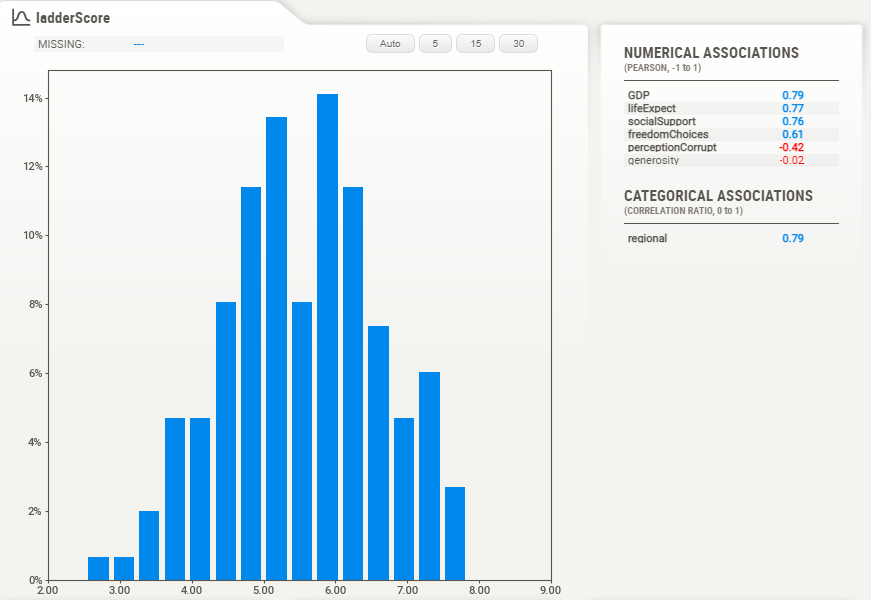

📌Hedef değişken için bağımsız değişkenleri korelasyon ile belirleme

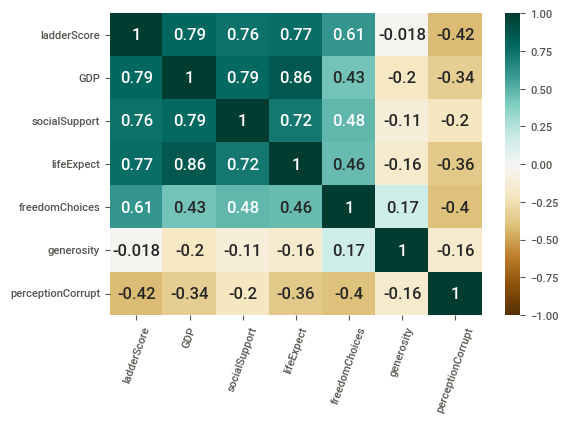

In [17]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.yticks(rotation = "horizontal")
plt.xticks(rotation = "70");

📌Korelasyon sıralamasına göre ladderScore'un sırasıyla GDP, Life Expect ve Social Support ile güçlü ilişkileri olduğu görülüyor.

In [18]:
cor =df.corr()
cor['ladderScore']

ladderScore          1.000000
GDP                  0.789760
socialSupport        0.756888
lifeExpect           0.768099
freedomChoices       0.607753
generosity          -0.017799
perceptionCorrupt   -0.421140
Name: ladderScore, dtype: float64

📌Türkiye genel mutluluk ortalamasının altında kalarak lowerHappy 0 olarak değer almıştır.

In [19]:
happiness_mean = df['ladderScore'].mean()
df['lowerHappy'] = df['ladderScore'].apply(lambda x: 0 if x < happiness_mean else 1)
print(df[df["country"].map(lambda country: "Turkey" in country)])
print(f'Ortalama mutluluk: {happiness_mean}')

    country                      regional  ...  perceptionCorrupt  lowerHappy
103  Turkey  Middle East and North Africa  ...              0.776           0

[1 rows x 10 columns]
Ortalama mutluluk: 5.532838926174494


📌Veri kümemizin dengeli veya dengesiz olduğunu görelim

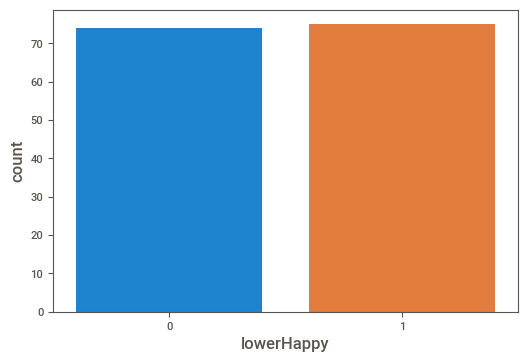

In [20]:
sns.countplot(df['lowerHappy'])

📌Mutlu kategorisine giren ülkelerde daha yüksek gelir, sosyal yardım, sağlıklı hayat beklentisi ve özgür seçimler yapabilmek varken mutsuz ülkelerde yolsuzluk fazladır. <br>
📌Cömertlikte mutsuz ülkeler üstünlük gösterebilmiştir.

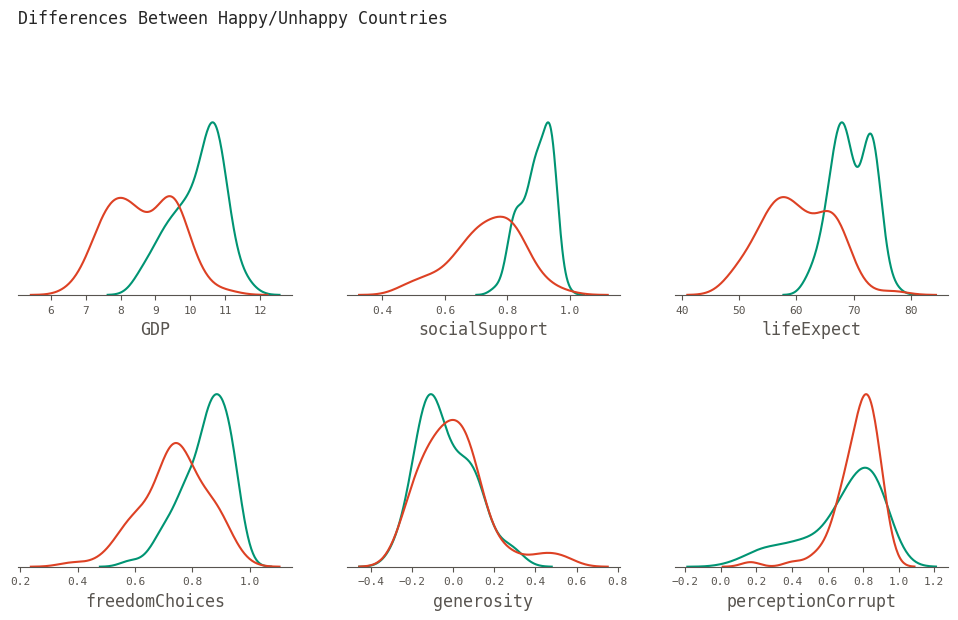

In [21]:
# colours
low_c = '#dd4124'
high_c = '#009473'
plt.rcParams["font.family"] = "monospace"

fig = plt.figure(figsize=(12, 6), dpi=100)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.5) #yazı için aralık

#2 satır 3 sütun table özellikler
plot = 0
for row in range(0, 2):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        locals()["ax"+str(plot)].set_axisbelow(True)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

Yes = df[df['lowerHappy'] == 1]
No = df[df['lowerHappy'] == 0]

for variable in continuous:
        sns.kdeplot(Yes[variable], ax=locals()["ax"+str(plot)], color=high_c)
        sns.kdeplot(No[variable],ax=locals()["ax"+str(plot)], color=low_c)
        plot += 1
        
Xstart, Xend = ax0.get_xlim()
Ystart, Yend = ax0.get_ylim()

ax0.text(Xstart, Yend+(Yend*0.5), 'Differences Between Happy/Unhappy Countries')


plt.show()

📌Yıllara göre Finlandiya & Türkiye Mutluluk Karşılaştırması

In [22]:
general_df = pd.read_csv("world-happiness-report.xls")
general_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


In [23]:
table_turkey = general_df.set_index('Country name').loc['Turkey']
table_turkey = table_turkey.set_index('year')
table_finland = general_df.set_index('Country name').loc['Finland']
table_finland = table_finland.set_index('year')

<Figure size 2000x1000 with 0 Axes>

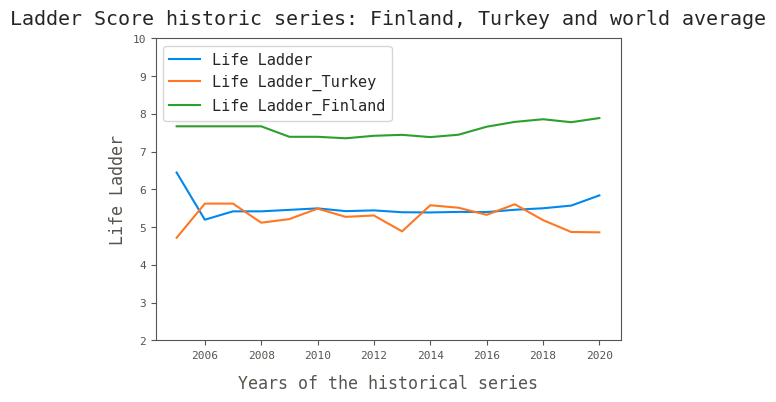

In [24]:
joint = table_turkey.join(table_finland, lsuffix='_Turkey',
    rsuffix='_Finland')

table_perAno = general_df.groupby('year').mean()

new_joint = table_perAno.join(joint , lsuffix='_Turkey',
    rsuffix='_Finland' )

fig = plt.figure(figsize=(20,10))
ax = new_joint[['Life Ladder', 'Life Ladder_Turkey', 'Life Ladder_Finland']].fillna(method='bfill').plot()
plt.title("Ladder Score historic series: Finland, Turkey and world average", pad=10)
ax.set_ylabel("Life Ladder")
ax.set_xlabel("Years of the historical series", labelpad=10)
plt.ylim(2, 10)
ax=0
plt.show()

📌Finlandiya 2008- 2009 aralığı ve 2019 yılı haricinde mutluluğunda artış görülüyor. 2019 için Covid-19 etkisi araştırılabilir. <br>
📌Türkiye için düzensiz bir durum söz konusudur. 2017 yılı itibari ile mutlulukta azalma var.Dünya mutluluk ortalamasının altında yer alır.

In [25]:
general_df=general_df.drop(["Positive affect","Negative affect"], axis = 1)
general_df.columns = ['country', 'year', 'ladderScore', 'GDP', 'socialSupport', 'lifeExpect', 'freedomChoices', 'generosity','perceptionCorrupt']

📌Sütunlar içerisinde NaN veriler mevcut.Ülkeler gruplandırılır ve doğru veriler ile doldurulmaya çalışılır ancak hala Nan veriler mevcut.Bu nedenle interpolasyon tekniği de uygulanır.

In [26]:
null_columns=general_df.columns[general_df.isnull().any()] #column names with null values
print(general_df[null_columns].isnull().sum())

GDP                   36
socialSupport         13
lifeExpect            55
freedomChoices        32
generosity            89
perceptionCorrupt    110
dtype: int64


In [27]:
for j in null_columns:
  general_df[j] = general_df[j].fillna(general_df.groupby('country')[j].transform('mean'))


In [28]:
general_df1=general_df[general_df.isnull().any(axis=1)]["country"]
general_df1[~general_df.duplicated('country')]

342                         China
423                          Cuba
699     Hong Kong S.A.R. of China
905                        Kosovo
1062                     Maldives
1280                 North Cyprus
1310                         Oman
1559                      Somalia
1562            Somaliland region
1596                  South Sudan
1768                 Turkmenistan
Name: country, dtype: object

In [29]:
general_df=general_df.interpolate(method="polynomial", order=2)


**Linear Regression (OLS)**

In [30]:
X = general_df[['year','GDP','socialSupport','lifeExpect','freedomChoices','generosity','perceptionCorrupt']]
y = general_df['ladderScore']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 0)

In [31]:
print("Eğitim kümesi boyutu (X) :", X_train.shape)
print("Eğitim kümesi boyutu (y) :",y_train.shape)
print("Test kümesi boyutu (X)   :", X_test.shape)
print("Test kümesi boyutu (y)   :", y_test.shape)

Eğitim kümesi boyutu (X) : (1364, 7)
Eğitim kümesi boyutu (y) : (1364,)
Test kümesi boyutu (X)   : (585, 7)
Test kümesi boyutu (y)   : (585,)


In [32]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)

LinearRegression()

📌$$ y = 27.627123287615902 - 0.01479442*year + 0.31359112*Gdp + 2.3182583*socialSupp +  0.03486269*lifeExpect + 1.29235237*freeChoice + 0.63116782*generosity- 0.51683425*perceptCorrupt $$





In [33]:
print('Değişkenler: \n', lrm.coef_)
print('Sabit değer (bias): \n', lrm.intercept_)

Değişkenler: 
 [-0.01479442  0.31359112  2.3182583   0.03486269  1.29235237  0.63116782
 -0.51683425]
Sabit değer (bias): 
 27.627123287615902


📌Adj. R-squared:	0.738 <br>
📌p-value 0.5'den az,ideal

In [34]:
X_train = sm.add_constant(X_train)
sonuclar = sm.OLS(y_train, X_train).fit()
sonuclar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ladderScore   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     550.7
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        08:10:17   Log-Likelihood:                -1144.9
No. Observations:                1364   AIC:                             2306.
Df Residuals:                    1356   BIC:                             2348.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                27.6271      7.876      3.508      0.000      12.177      43.077
year                 -0.0148      0.004     -3.769      0.000      -0.022      -0.007
GDP                   0.3136      0.027     11.831      0.000       0.262       0.366
socialSupport         2.3183      0.185     12.535      0.000       1.955       2.681
lifeExpect            0.0349      0.004      9.367      0.000       0.028       0.042
freedomChoices        1.2924      0.138      9.386      0.000       1.022       1.562
generosity            0.6312      0.103      6.103      0.000       0.428       0.834
perceptionCorrupt    -0.5168      0.099     -5.219      0.000      -0.711      -0.323
==============================================================================
Omnibus:                       19.514   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.319
Skew:                          -0.197   Prob(JB):                     5.24e-06
Kurtosis:                       3.522   Cond. No.                     1.04e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
predicted=lrm.predict(X_test)
expected= y_test

📌Tahmin Edilen Değer & Gerçek Değer

In [36]:
for p,e in zip(predicted[::50],expected[::50]):
  print(f'predicted: {p:.3f}, expected:{e:.3f}')

predicted: 5.055, expected:4.814
predicted: 4.681, expected:4.203
predicted: 5.613, expected:5.234
predicted: 6.137, expected:7.267
predicted: 4.805, expected:4.576
predicted: 5.336, expected:4.560
predicted: 4.802, expected:4.254
predicted: 5.254, expected:5.096
predicted: 5.208, expected:3.499
predicted: 4.840, expected:4.225
predicted: 6.402, expected:6.475
predicted: 5.272, expected:6.019


📌En mutsuz 100 ülke için feature ortalamaları

In [37]:
sort_general=general_df.sort_values(by=['ladderScore']).iloc[:100]
sort_general.mean()


year                 2013.800000
ladderScore             3.369000
GDP                     7.825873
socialSupport           0.628550
lifeExpect             53.403800
freedomChoices          0.658387
generosity             -0.001617
perceptionCorrupt       0.761467
dtype: float64

📌En mutlu 100 ülke için feature ortalamaları

In [38]:
sort_general=general_df.sort_values(by=['ladderScore']).iloc[-100:]
sort_general.mean()

year                 2012.890000
ladderScore             7.537610
GDP                    10.822200
socialSupport           0.944991
lifeExpect             71.833400
freedomChoices          0.923220
generosity              0.160135
perceptionCorrupt       0.385537
dtype: float64

📌Mutluluk ortalaması genel ortalamadan düşük olan ilk 100 ülkenin özellik değerleri ile 2022 yılı mutluluk tahmini

In [39]:
lrm.predict([[2022,7.825873,0.628550,53.403800,0.658387,-0.001617,0.761467]])

array([3.94217037])

📌Mutluluk ortalaması genel ortalamadan yüksek olan ilk 100 ülkenin özellik değerleri ile 2022 yılı mutluluk tahmini

In [40]:
lrm.predict([[2022,10.822200,0.944991,71.833400,0.923220, 0.160135, 0.385537]])

array([6.89653311])

**Xgboost+Hyperparameter-tuning**

📌Bu model ülkenin mutlu & mutsuz olma durumunu tahmin eder<br>
📌Binary Sınıflandırma

In [41]:
X = df[['GDP','lifeExpect','socialSupport']]
y = df['lowerHappy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
clf = XGBClassifier()

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

random_cv=RandomizedSearchCV(estimator=clf,param_distributions=params,
                             cv=5,n_iter=5,scoring='roc_auc',n_jobs=1,verbose=3,return_train_score=True,random_state=121)
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.964, test=0.935) total time=   0.0s
[CV 2/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.942, test=0.982) total time=   0.0s
[CV 3/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.949, test=1.000) total time=   0.0s
[CV 4/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.971, test=0.868) total time=   0.0s
[CV 5/5] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=5, subsample=0.6;, score=(train=0.966, test=0.955) total time=   0.0s
[CV 1/5] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=10, subsample=0.6;, score=(train=0.500, test=0.500) total time=   0.0s
[CV 2/5] END colsample_bytree=1.0, gamma=2, max_depth=4, min_child_weight=1

RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=5, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=121, return_train_score=True, scoring='roc_auc',
                   verbose=3)

In [43]:
#best parameter 
random_cv.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.8}

In [44]:
clf = XGBClassifier(colsample_bytree= 0.8,
 gamma= 1.5,
 max_depth= 5,
 min_child_weigh= 1,
 subsample= 0.6)

clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, gamma=1.5, max_depth=5, min_child_weigh=1,
              subsample=0.6)

In [45]:
y_predict=clf.predict(X_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.92      0.81      0.86        27

    accuracy                           0.84        45
   macro avg       0.84      0.85      0.84        45
weighted avg       0.85      0.84      0.85        45



In [46]:
print("For test data: \n")
pred = clf.predict(X_test)
print(pd.crosstab(y_test, pred, rownames = ['Actual'], colnames = ['Predictions']))
print("Test accuracy:", accuracy_score(y_test,pred))

print("\nFor training data: \n")
pred_train = clf.predict(X_train)
print(pd.crosstab(y_train, pred_train, rownames = ['Actual'], colnames = ['Predictions']))
print("Training accuracy:", accuracy_score(y_train,pred_train))

For test data: 

Predictions   0   1
Actual             
0            16   2
1             5  22
Test accuracy: 0.8444444444444444

For training data: 

Predictions   0   1
Actual             
0            51   5
1             3  45
Training accuracy: 0.9230769230769231


**Artificial neural networks (ANN)**

📌Modelin girdi sayısını belirleme

In [47]:
girdi_adedi = X_train.shape[1]
print(girdi_adedi)

3


📌16 nöronlu ilk katmanı modele ekle

In [48]:
siniflandirma_modeli = Sequential()

siniflandirma_modeli.add(Dense(16, 
                               activation='relu', 
                               input_shape = (girdi_adedi,), 
                               name = "Gizli_Katman_1"))

📌4 nöronlu ikinci katman

In [49]:
siniflandirma_modeli.add(Dense(4, 
                               activation='relu', 
                               input_shape = (girdi_adedi,), 
                               name = "Gizli_Katman_2"))

📌Çıktı katmanı<br>
Bu katman için aktivasyon fonksiyonu olarak sigmoid kullarak  0 ila 1 arasında bir değer döndürmesini sağlayacağız.

In [50]:
siniflandirma_modeli.add(Dense(1, activation='sigmoid', name = "Cikti"))

📌Model özeti

In [51]:
siniflandirma_modeli.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Gizli_Katman_1 (Dense)      (None, 16)                64        
                                                                 
 Gizli_Katman_2 (Dense)      (None, 4)                 68        
                                                                 
 Cikti (Dense)               (None, 1)                 5         
                                                                 
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


📌Modeli derlemek<br> Optimizer olarak <code>adam</code> algoritması kullanılır. Kayıp fonksiyonu olarak <code>binary_crossentropy</code>, modelin performansı için de <code>accuracy</code> kullanılır.

In [52]:
siniflandirma_modeli.compile(optimizer ='adam',
                             loss='binary_crossentropy', 
                             metrics =['accuracy'])

In [53]:
X_egitim=np.asarray(X_train).astype(np.float)
X_test=np.asarray(X_test).astype(np.float)
y_egitim=np.asarray(y_train).astype(np.float)
y_test=np.asarray(y_test).astype(np.float)

In [54]:
siniflandirma_modeli.fit(X_egitim, y_egitim, epochs=100, verbose=0)

📌Model performansına <code>evaluate</code> komutuyla bakılır. <code>evaluate()</code> metodu kayıp fonksiyonunu ve metrik değerini döndürmektedir.

In [55]:
dogruluk_egitim = siniflandirma_modeli.evaluate(X_egitim, y_egitim)[1]
dogruluk_test = siniflandirma_modeli.evaluate(X_test, y_test)[1]

print("\nEğitim kümesi doğruluk değeri : {:.3f}".format(dogruluk_egitim))
print("Test kümesi doğruluk değeri   : {:.3f}".format(dogruluk_test))

2/2 [==============================] - 0s 7ms/step - loss: 0.6558 - accuracy: 0.6000

Eğitim kümesi doğruluk değeri : 0.558
Test kümesi doğruluk değeri   : 0.600


**Conclusion**

✅Mutlu kategorisine giren ülkelerde daha yüksek gelir, sosyal yardım, sağlıklı hayat beklentisi ve özgür seçimler yapabilmek varken mutsuz ülkelerde yolsuzluk fazladır.Cömertlikte ise mutsuz ülkeler üstünlük gösterebilmiştir.<br>
✅Batı Avrupa ve Kuzey Amerika bölgelerinin sağlıklı yaşam beklentisi ve mutluluk skoru yüksek.<br>
✅En mutlu ülke Finlandiya, en mutsuz ülke Afganistan.<br>
✅Türkiye(4,94), genel mutluluk ortalamasının(5.53) altında kalmıştır.<br>
✅2005 yılından 2021 yılına dek genel mutluluk ortalamasında azalma var.<br>
✅2022 yılı için mutluluk düzeyi ortalamanın altında kalan ülkeler için ort. mutluluk tahmini :3.94<br>
✅2022 yılı için mutluluk düzeyi ortalamanın üzerinde  yer alan ülkeler için ort. mutluluk tahmini :6.89<br>
✅ML tarafından en güçlü tahmin Hiperparametre ayarlaması yapılan Xgboost algoritmasının performansıdır.